<a href="https://colab.research.google.com/github/nafi-rahman/Comparative-Study-of-various-techniques-using-Deep-Learning-for-Brain-Tumor-Detection/blob/main/BrainTumorCAIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


# Specify the input size for CAIT
input_size = (224, 224)

# Load label names from subdirectory names
isolated_train_path = "/content/drive/MyDrive/Database/BrainTumor(10K_new)/Training"
isolated_test_path = "/content/drive/MyDrive/Database/BrainTumor(10K_new)/Testing"
label_names = sorted(os.listdir(isolated_train_path))

# Create a dictionary to map label names to their numerical indexes
label_to_index = {label: index for index, label in enumerate(label_names)}

# Function to apply the recommended transformations
def get_cait_transforms(input_size):
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    transformations = transforms.Compose([
        transforms.Resize(input_size, interpolation=3),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    return transformations


# Apply transformations to training images
train_dataset = ImageFolder(root=isolated_train_path, transform=get_cait_transforms(input_size), target_transform=lambda x: label_to_index[train_dataset.classes[x]])

# Assuming you have the test_loader ready
test_dataset = ImageFolder(root=isolated_test_path, transform=get_cait_transforms(input_size), target_transform=lambda x: label_to_index[test_loader.dataset.classes[x]])

# Create DataLoaders
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



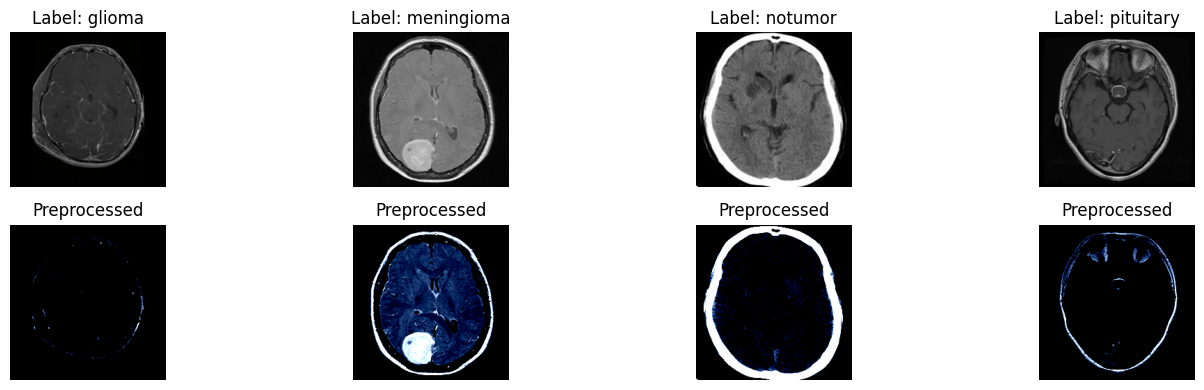

In [ ]:
# Get one example image from each class
example_images = []
example_labels = []
seen_labels = set()

for images, labels in test_loader:
    for image, label in zip(images, labels):
        label_idx = label.item()
        if label_idx not in seen_labels:
            example_images.append(image)
            example_labels.append(label_idx)
            seen_labels.add(label_idx)
        if len(example_images) >= len(label_names):
            break
    if len(example_images) >= len(label_names):
        break

# Visualize the example images
num_samples = len(example_images)
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 4))

for i in range(num_samples):
    # Original image
    orig_image = (example_images[i].numpy() * np.array([0.229, 0.224, 0.225])[:, np.newaxis, np.newaxis]) + np.array([0.485, 0.456, 0.406])[:, np.newaxis, np.newaxis]
    orig_label_index = example_labels[i]
    orig_label_name = label_names[orig_label_index]
    axes[0, i].imshow(np.transpose(orig_image, (1, 2, 0)))
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Label: {orig_label_name}')

    # Preprocessed image
    preprocessed_image = np.transpose(example_images[i], (1, 2, 0))
    axes[1, i].imshow(preprocessed_image)
    axes[1, i].axis('off')
    axes[1, i].set_title('Preprocessed')

plt.tight_layout()
plt.show()


In [ ]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor


# Load the pre-trained CAIT model
model = timm.create_model('cait_s24_224', pretrained=True, num_classes=len(label_names)).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming you have the train_loader and test_loader ready
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and print average loss for the epoch
    average_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {average_loss:.4f}")

# Evaluate on validation set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on validation set: {accuracy:.2f}%")


Epoch [1/10] - Loss: 1.1893
Epoch [2/10] - Loss: 1.0337
Epoch [3/10] - Loss: 0.8270
Epoch [4/10] - Loss: 0.6952
Epoch [5/10] - Loss: 0.6019
Epoch [6/10] - Loss: 0.5782
Epoch [7/10] - Loss: 0.6713
Epoch [8/10] - Loss: 0.5471
Epoch [9/10] - Loss: 0.4931
Epoch [10/10] - Loss: 0.4536
Accuracy on validation set: 79.90%


In [ ]:
from sklearn.metrics import f1_score

# Evaluate on validation set
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate F1 score
f1_macro = f1_score(true_labels, predicted_labels, average='macro')
f1_micro = f1_score(true_labels, predicted_labels, average='micro')
f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")


F1 Score (Macro): 0.7926
F1 Score (Micro): 0.7990
F1 Score (Weighted): 0.7926


Confusion matrix, without normalization
[[401  76   6  17]
 [ 76 281 112  31]
 [  5   6 482   7]
 [ 29  18  19 434]]


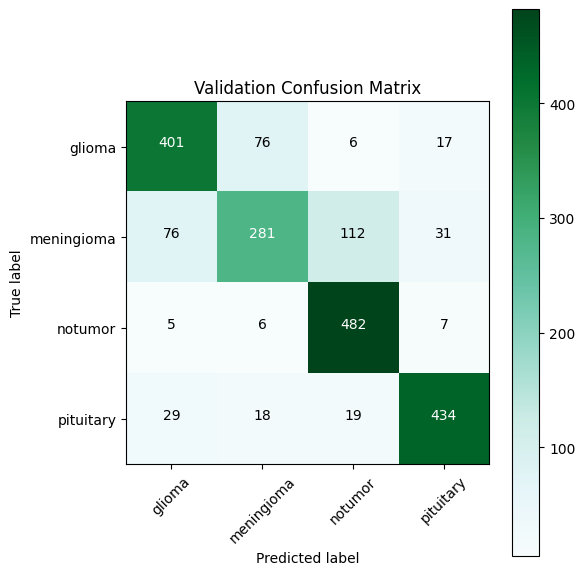

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Evaluate on validation set
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate confusion matrix
val_cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.BuGn):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

class_names = label_names  # Use your label names here
plot_confusion_matrix(val_cm, classes=class_names, title='Validation Confusion Matrix')


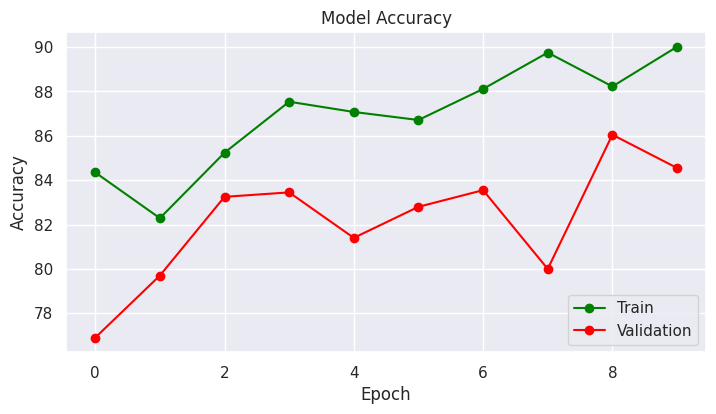

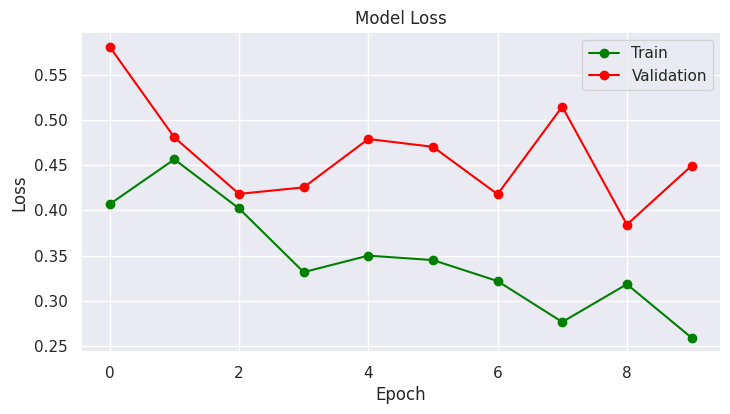

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns


# Lists to store training history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100 * correct_val / total_val)

# Plot training and validation curves
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(train_accuracies, 'o-', color="Green")
plt.plot(val_accuracies, 'o-', color="Red")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(train_losses, 'o-', color="Green")
plt.plot(val_losses, 'o-', color="Red")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

plt.show()
